In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from plotly.subplots import make_subplots

In [2]:
#vscode-notebook-cell:/Users/prajwal/Developer/assessment/Zeotap/EDA_Business_Insights.ipynb#W1sZmlsZQ%3D%3D
tqdm.pandas()

pio.renderers.default = "notebook_connected"

# Root directory of the project
os.chdir('/Users/prajwal/Developer/assessment')

In [3]:
# Load datasets
customers = pd.read_csv("Zeotap/Data/Customers.csv")
products = pd.read_csv("Zeotap/Data/Products.csv")
transactions = pd.read_csv("Zeotap/Data/Transactions.csv")

In [4]:
# Display's the information of the datasets
customers.info()
products.info()
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  


In [5]:
# Merge datasets
df = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [6]:
df.isnull().sum()

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price_x            0
CustomerName       0
Region             0
SignupDate         0
ProductName        0
Category           0
Price_y            0
dtype: int64

In [7]:
# Convert dates
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['SignupDate'] = pd.to_datetime(df['SignupDate'])
df['PurchaseDif'] = (df['TransactionDate'] - df['SignupDate']).dt.days # Calculate the lag between signup and purchase

### Insights and Observations 1: Revenue Distribution by region and product category

1. We can see that the revenue distribution is not evenly distributed across regions and product categories.

2. The top 3 regions with the highest revenue and top 2 product category are:
    * South America - 219,352 [Books, Electronics]
    * Europe - 166,254 [Books, Electronics]
    * North America - 152,313 [Electronics, Books]
    
3. While Asia has Clothing as the top product category & it has the lowest revenue.

In [8]:
#(Sunburst Chart)
region_category_rev = df.groupby(['Region', 'Category'])['TotalValue'].sum().reset_index()
fig1 = px.sunburst(region_category_rev, path=['Region', 'Category'], values='TotalValue', title='<b>Revenue Distribution by Region & Product Category</b>',
                   color_continuous_scale='Plasma')
fig1.update_layout(margin=dict(t=50, b=10, l=20, r=10))

fig1.show()

![Revenue Distribution by Region & Category.png](<attachment:Revenue Distribution by Region & Category.png>)
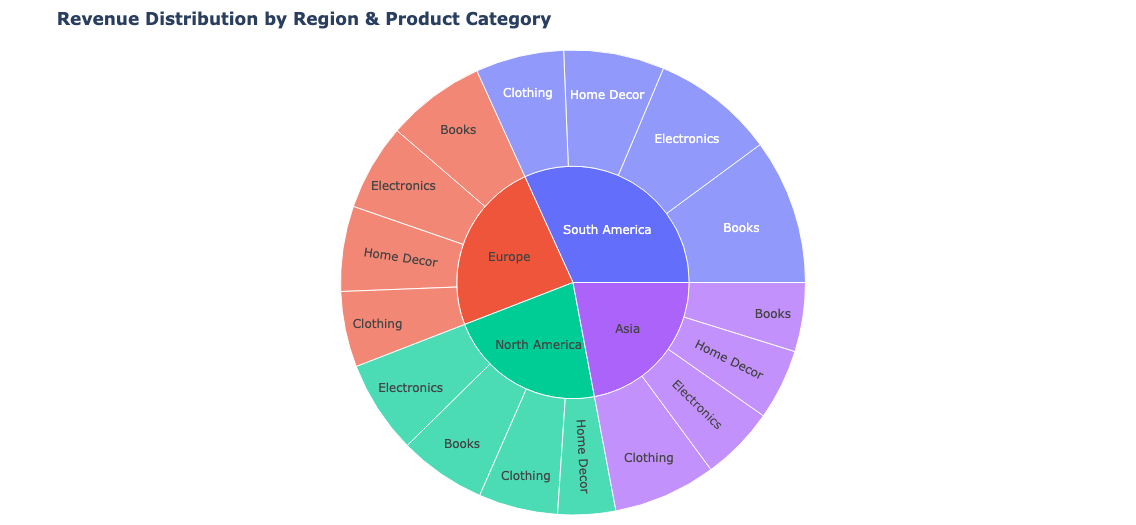

### Insights and Observations 2: Monthly Revenue and Active Users

1. As we can see from the graph, the revenue is highest in the month of January and lowest in the month of November.

In [9]:
# (Dual-axis Line Chart)
df['TransactionMonth'] = df['TransactionDate'].dt.to_period('M').dt.to_timestamp()
monthly_stats = df.groupby('TransactionMonth').agg(Revenue=('TotalValue', 'sum'),Customers=('CustomerID', 'nunique')).reset_index()

fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=monthly_stats['TransactionMonth'], y=monthly_stats['Revenue'],name='Revenue', line=dict(color='#FF6B6B')), secondary_y=False) # Revenue Line
fig2.add_trace(go.Scatter(x=monthly_stats['TransactionMonth'], y=monthly_stats['Customers'],name='Active Customers', line=dict(color='#4ECDC4')), secondary_y=True) # Active Customers Line
fig2.update_layout(title='<b>Monthly Revenue vs Active Customers</b>',xaxis_title='Month', template='plotly_dark')
fig2.update_yaxes(title_text='Revenue (USD)', secondary_y=False)
fig2.update_yaxes(title_text='Active Customers', secondary_y=True)
fig2.show()

![Customer Acquisition & Revenue Trends.png](<attachment:Customer Acquisition & Revenue Trends.png>)

### Insights and Observations 3: Price Elasticity Analysis (3D Scatter Plot)

1. The 3D scatter plot shows the relationship between the Quantity, Price, and TotalValue of the products.

2. We can see as quantity increases, the total value also increases.

3. The price of the product is also a factor in determining the total value of the product.

4. Electronics products have a higher price compared to other product categories.

In [10]:
# (3D Scatter Plot)
product_stats = df.groupby(['ProductID', 'Category']).agg(Avg_Price=('Price_x', 'mean'),
    Total_Quantity=('Quantity', 'sum'),
    Total_Revenue=('TotalValue', 'sum')
).reset_index()

fig3 = px.scatter_3d(product_stats, x='Avg_Price', y='Total_Quantity', z='Total_Revenue',
                    color='Category', size='Total_Revenue',
                    title='<b>3D Price Elasticity Analysis</b>',
                    labels={'Avg_Price':'Price (USD)', 'Total_Quantity':'Units Sold'},
                    hover_name='ProductID', template='plotly_dark')
fig3.update_layout(scene=dict(camera=dict(up=dict(x=0, y=0, z=1),
                                        eye=dict(x=1.5, y=1.5, z=0.1))))
fig3.show()


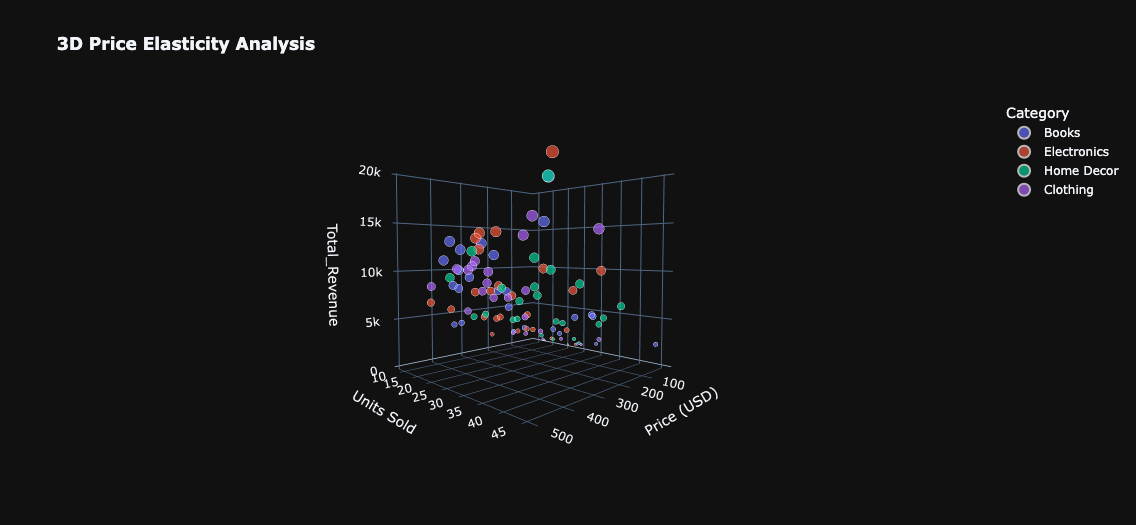

### Insights and Observations 4: Customer Lifetime Value Analysis (Bubble Chart)

1. This chart gives us an idea of the customer lifetime value based on the revenue generated by the customers.

2. Its very important to retain customers with high lifetime value as they contribute more to the revenue.

3. The size of the bubble represents the revenue generated by the customer.

In [11]:
# (Bubble Chart)
customer_lifetime = df.groupby('CustomerID').agg(
    Total_Spend=('TotalValue', 'sum'),
    Transaction_Count=('TransactionID', 'nunique'),
    Tenure_Days=('SignupDate', lambda x: (pd.Timestamp.today() - x.max()).days)
).reset_index()

fig4 = px.scatter(customer_lifetime, x='Tenure_Days', y='Total_Spend',
                 size='Transaction_Count', color='Total_Spend',
                 title='<b>Customer Lifetime Value Analysis</b>',
                 labels={'Tenure_Days':'Customer Tenure (Days)', 
                        'Total_Spend':'Total Spend (USD)'},
                 color_continuous_scale='Plasma',
                 trendline='lowess',
                 template='ggplot2')
fig4.update_layout(showlegend=False)
fig4.show() 

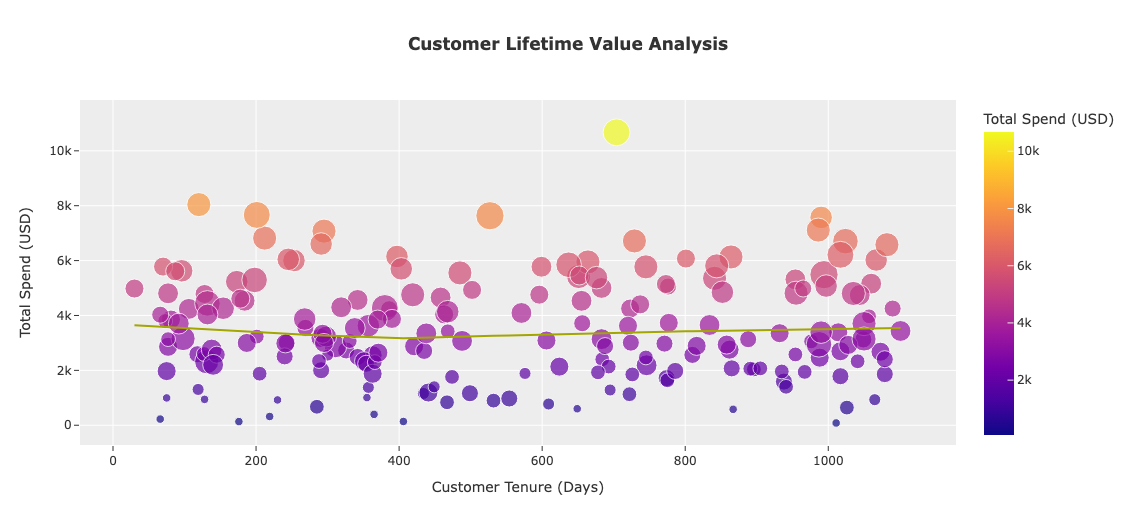

In [12]:
# (Calendar Visualization)
df['TransactionHour'] = df['TransactionDate'].dt.hour
df['TransactionDay'] = df['TransactionDate'].dt.day_name()
heatmap_data = df.groupby(['TransactionDay', 'TransactionHour'])['TotalValue'].sum().unstack()

fig5 = px.imshow(heatmap_data, 
                labels=dict(x="Hour of Day", y="Day of Week", color="Revenue"),
                title='<b>Transaction Value Heatmap by Time</b>',
                color_continuous_scale='Plasma')

fig5.update_layout(xaxis_nticks=24, yaxis={'categoryorder':'array','categoryarray':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']})
fig5.show()

### Insights and Observations 6: Revenue Distribution by Continent (Choropleth Map)

1. This chart provides a visual representation of the revenue distribution across different continents.

2. The map is color-coded to indicate the revenue generated in each continent.

In [13]:
continent_to_countries = {
    'South America': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Peru'],
    'Asia': ['China', 'India', 'Japan', 'South Korea', 'Vietnam'],
    'North America': ['United States', 'Canada', 'Mexico'],
    'Europe': ['Germany', 'France', 'United Kingdom', 'Italy', 'Spain'],
    'Africa': ['Nigeria', 'South Africa', 'Kenya', 'Egypt', 'Morocco'],
}
country_data = []
for region, countries in continent_to_countries.items():
    for country in countries:
        row = {
            'Region': region,
            'Country': country
        }
        country_data.append(row)
country_df = pd.DataFrame(country_data)
country_df.describe()

,Region,Country
count,23,23
unique,5,23
top,South America,Argentina
freq,5,1


In [14]:
continent_df = df.groupby('Region').agg(
    TotalRevenue=('TotalValue', 'sum'),
    AvgOrderValue=('TotalValue', 'mean'),
    CustomerCount=('CustomerID', 'nunique')
).reset_index()

choropleth_df = country_df.merge(continent_df, on='Region', how='left')
choropleth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         23 non-null     object 
 1   Country        23 non-null     object 
 2   TotalRevenue   18 non-null     float64
 3   AvgOrderValue  18 non-null     float64
 4   CustomerCount  18 non-null     float64
dtypes: float64(3), object(2)
memory usage: 1.0+ KB


In [15]:
# Create the choropleth map (Choropleth Map)
fig = px.choropleth(
    choropleth_df,
    locations="Country",
    locationmode="country names",
    color="TotalRevenue",
    hover_name="Country",
    hover_data=["Region", "AvgOrderValue", "CustomerCount"],
    projection="natural earth",
    title="<b>Revenue Distribution by Continent</b>",
    color_continuous_scale='Viridis',
    scope='world',
    height=600
)
fig.update_geos(showcountries=True, showcoastlines=True)
fig.show()

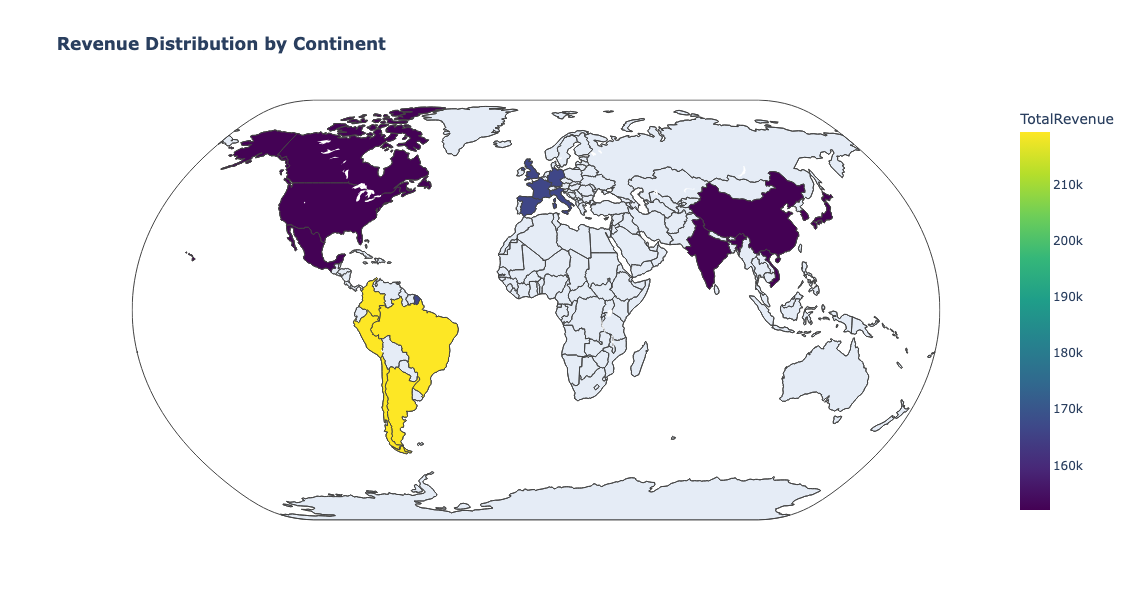

### Insights and Observations 7: Price Elasticity Analysis (Bar & Line Chart)

1. This chart shows the relationship between the price of the product and the quantity sold.

2. The chart shows that as the price of the product increases, the quantity sold decreases.

3. This insight can be used to determine the optimal price point for the products.


In [16]:
price_elasticity = df.groupby(pd.qcut(df['Price_x'], 10)).agg(
    AvgPrice=('Price_x', 'mean'),
    TotalQuantity=('Quantity', 'sum'),
    TotalRevenue=('TotalValue', 'sum')
).reset_index()

price_elasticity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Price_x        10 non-null     category
 1   AvgPrice       10 non-null     float64 
 2   TotalQuantity  10 non-null     int64   
 3   TotalRevenue   10 non-null     float64 
dtypes: category(1), float64(2), int64(1)
memory usage: 838.0 bytes


In [17]:
# (Bar & Line Chart)
fig = go.Figure()
fig.add_trace(go.Bar(x=price_elasticity['AvgPrice'],
                    y=price_elasticity['TotalQuantity'],
                    name='Quantity Sold',
                    marker_color='#636EFA'))
fig.add_trace(go.Scatter(x=price_elasticity['AvgPrice'],
                        y=price_elasticity['TotalRevenue'],
                        name='Revenue',
                        mode='lines+markers',
                        line=dict(color='#EF553B', width=3),
                        yaxis='y2'))

fig.update_layout(
    title="<b>Price Elasticity Analysis</b>",
    xaxis_title="Price Brackets (USD)",
    yaxis=dict(title="Quantity Sold", showgrid=False),
    yaxis2=dict(title="Revenue", overlaying='y', side='right'),
    template="plotly_white",
    hovermode="x unified"
)
fig.show()

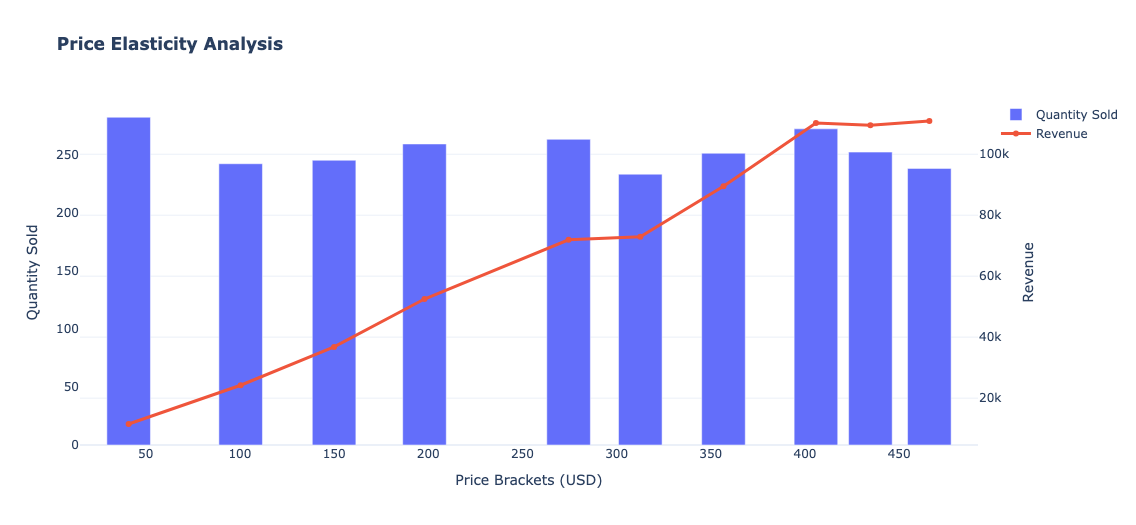

### Insights and Observations 8: Top 20 Customers by CLV

1. The CLV stands for Customer Lifetime Value, which is the total revenue generated by the customer.

2. The top 20 customers with the highest CLV are shown in the chart.

3. It is important to retain these customers as they contribute significantly to the revenue.

4. Loyalty programs and personalized offers can be used to retain these customers.

In [18]:
clv_funnel = df.groupby('CustomerID').agg(
    FirstPurchase=('TransactionDate', 'min'),
    LastPurchase=('TransactionDate', 'max'),
    TotalSpend=('TotalValue', 'sum'),
    PurchaseCount=('TransactionID', 'nunique')
).sort_values('TotalSpend', ascending=False).head(20)

clv_funnel.describe()

,FirstPurchase,LastPurchase,TotalSpend,PurchaseCount
count,20,20,20.000000,20.000000
mean,2024-02-24 11:02:05.999999744,2024-11-19 15:09:41.749999872,6888.982000,8.050000
min,2024-01-01 16:46:56,2024-08-26 13:10:31,5950.420000,5.000000
25%,2024-01-29 02:08:37,2024-10-31 16:10:39.500000,6117.500000,7.000000
50%,2024-02-14 15:31:53.500000,2024-12-07 19:34:13,6656.165000,8.000000
75%,2024-02-28 14:43:11,2024-12-19 23:30:28.500000,7226.717500,8.250000
max,2024-07-25 15:20:14,2024-12-26 14:40:03,10673.870000,11.000000
std,NaN,NaN,1099.835635,1.394538


In [ ]:
# funnel chart
fig = px.funnel(clv_funnel.reset_index(),
               x='TotalSpend',
               y='CustomerID',
               color='PurchaseCount',
               title="<b>Top 20 Customers by CLV</b>",
               labels={'TotalSpend':'Total Spend (USD)', 
                      'PurchaseCount':'Transactions'},
               height=800,
               template="ggplot2")
fig.update_traces(textposition="inside", 
                 textinfo="value+percent previous")
fig.show()

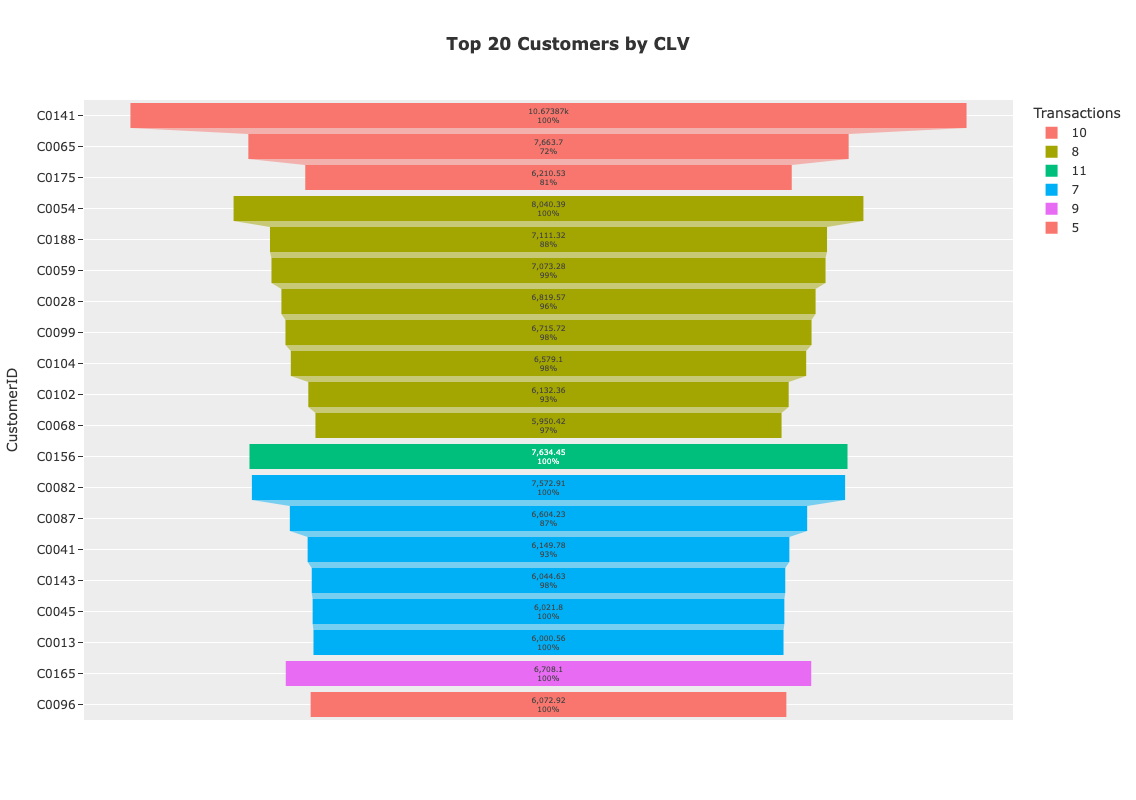

### Insights and Observations 9: Product Performance Analysis

1. This analysis shows the performance of the products and combining other analysis we see earlier.

3. Sales distribution by product category shows that Books has the highest sales.

In [20]:
product_perf = df.groupby(['Category', 'ProductName']).agg(
    TotalSales=('Quantity', 'sum'),
    TotalRevenue=('TotalValue', 'sum'),
    AvgDiscount=('Price_y', lambda x: ((x.mean() - df['Price_x'].mean())/x.mean())*100)
).reset_index()

fig = make_subplots(rows=2, cols=2,
                   specs=[[{"type": "sunburst"}, {"type": "treemap"}],
                         [{"type": "bar", "colspan": 2}, None]],
                   subplot_titles=("<b>Sales Distribution</b>", 
                                  "<b>Revenue Contribution</b>", 
                                  "<b>Discount Impact Analysis</b>"))

# Sunburst Chart
fig.add_trace(px.sunburst(product_perf, 
                         path=['Category', 'ProductName'], 
                         values='TotalSales').data[0],
             row=1, col=1)

# Treemap
fig.add_trace(px.treemap(product_perf,
                        path=['Category', 'ProductName'],
                        values='TotalRevenue',
                        color='AvgDiscount',
                        color_continuous_scale='RdYlGn_r').data[0],
             row=1, col=2)

# Bar Chart
fig.add_trace(go.Bar(x=product_perf.groupby('Category')['AvgDiscount'].mean().index,
                    y=product_perf.groupby('Category')['AvgDiscount'].mean().values,
                    marker=dict(color=product_perf.groupby('Category')['TotalRevenue'].sum().values,
                              colorscale='Viridis')),
             row=2, col=1)

fig.update_layout(height=1000, 
                 title_text="<b>Product Performance Dashboard</b>", 
                 showlegend=False)
fig.show()

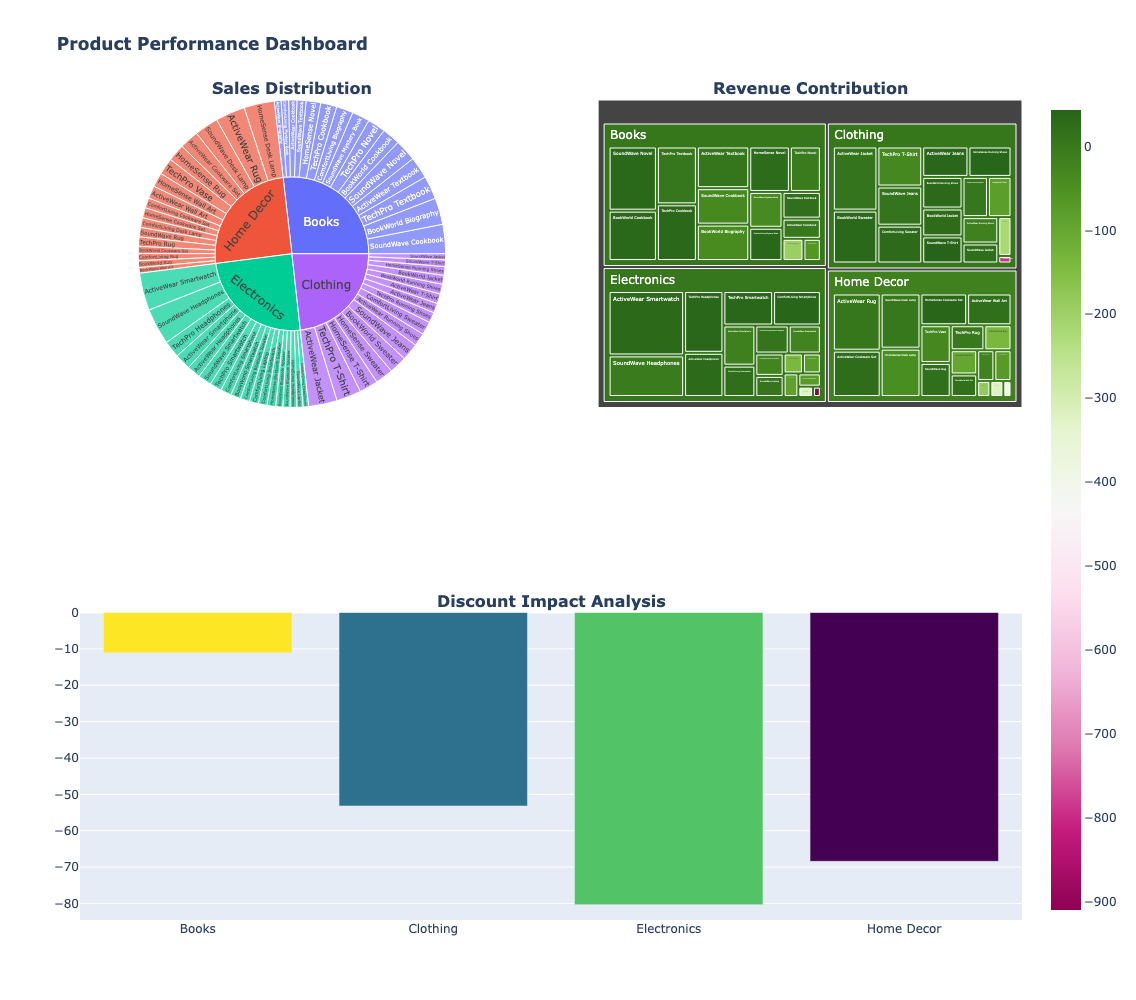